# HVM Startup Shear

**Hybrid Vitrimer Model — TST-driven stress overshoot**

## Physical Motivation

Startup shear at constant rate $\dot\gamma$ is the key experiment for probing
**mechanochemical coupling** in vitrimers. As stress builds during startup, the TST
term $\cosh(V_{act} \sigma_{VM}^E / RT)$ accelerates bond exchange, which relaxes
the E-network stress faster than it can accumulate. This competition produces a
**stress overshoot** — a signature of TST feedback absent in conventional Maxwell
models.

The overshoot magnitude and position are directly controlled by $V_{act}$
(activation volume), making startup shear the primary protocol for determining
this parameter. Materials with strong mechanochemical coupling (large $V_{act}$)
show prominent overshoots; those with weak coupling show monotonic approach to
steady state.

> **Handbook:** See [HVM Protocol Derivations](../../docs/source/models/hvm/hvm_protocols.rst) for the startup ODE and analytical constant-rate solution. See [HVM Knowledge Extraction](../../docs/source/models/hvm/hvm_knowledge.rst) for the role of startup in the multi-protocol fitting strategy (step 4).

## Learning Objectives

- Simulate constant-rate startup from equilibrium
- Observe stress overshoot from TST mechanochemical feedback
- Compare TST coupling modes (stress vs stretch)
- Examine rate-dependent overshoot position and magnitude

## Prerequisites

- **Notebook 01** (SAOS) — HVM architecture, parameter meanings, TST kinetics

## Estimated Runtime

- ~2 min (ODE integration)

In [1]:
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models import HVMLocal

jax, jnp = safe_import_jax()
verify_float64()
import os
import sys

sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

## 2. Theory

In startup shear at constant $\dot{\gamma}$, the stress initially grows linearly:

$$\sigma(t \to 0) \approx (G_P + G_E + G_D) \dot{\gamma} t$$

With TST kinetics, stress accelerates bond exchange, which relaxes the E-network
stress, creating an **overshoot** followed by decay to steady state.

At steady state:
- $\sigma_E = 0$ (natural state fully tracks deformation)
- $\sigma_P = G_P \gamma$ (grows linearly)
- $\sigma_D = (G_D / k_d^D) \dot{\gamma}$ (Newtonian viscous)

## 3. Single-Rate Startup

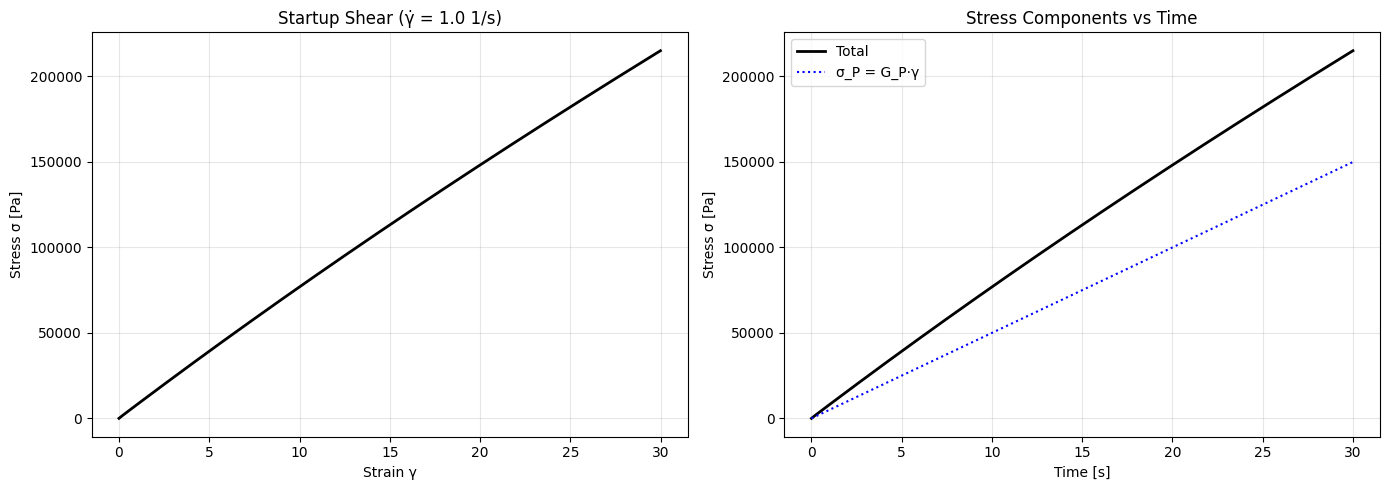

In [3]:
model = HVMLocal(kinetics="stress")
model.parameters.set_value("G_P", 5000.0)
model.parameters.set_value("G_E", 3000.0)
model.parameters.set_value("G_D", 1000.0)
model.parameters.set_value("nu_0", 1e10)
model.parameters.set_value("E_a", 80e3)
model.parameters.set_value("V_act", 1e-4)  # Strong coupling for visible overshoot
model.parameters.set_value("T", 350.0)
model.parameters.set_value("k_d_D", 10.0)

t = np.linspace(0.01, 30, 300)
gamma_dot = 1.0

result = model.simulate_startup(t, gamma_dot=gamma_dot, return_full=True)
stress = result["stress"]
strain = result["strain"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(strain, stress, "k-", lw=2)
ax1.set_xlabel("Strain γ")
ax1.set_ylabel("Stress σ [Pa]")
ax1.set_title(f"Startup Shear (γ̇ = {gamma_dot} 1/s)")
ax1.grid(True, alpha=0.3)

# Time domain
ax2.plot(t, stress, "k-", lw=2, label="Total")
ax2.plot(t, model.G_P * np.array(strain), "b:", lw=1.5, label="σ_P = G_P·γ")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Stress σ [Pa]")
ax2.set_title("Stress Components vs Time")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

## 4. Rate Dependence

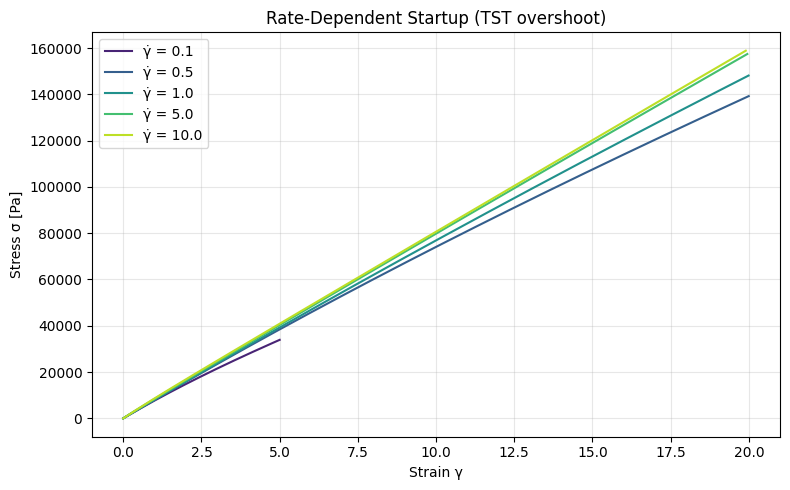

In [4]:
rates = [0.1, 0.5, 1.0, 5.0, 10.0]
colors = plt.cm.viridis(np.linspace(0.1, 0.9, len(rates)))

fig, ax = plt.subplots(figsize=(8, 5))

for gd, color in zip(rates, colors):
    t_end = min(50.0, 20.0 / gd)
    t_r = np.linspace(0.01, t_end, 200)
    result = model.simulate_startup(t_r, gamma_dot=gd, return_full=True)
    ax.plot(result["strain"], result["stress"], "-", color=color, lw=1.5,
            label=f"γ̇ = {gd}")

ax.set_xlabel("Strain γ")
ax.set_ylabel("Stress σ [Pa]")
ax.set_title("Rate-Dependent Startup (TST overshoot)")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
display(fig)
plt.close(fig)

## 5. Internal State Evolution

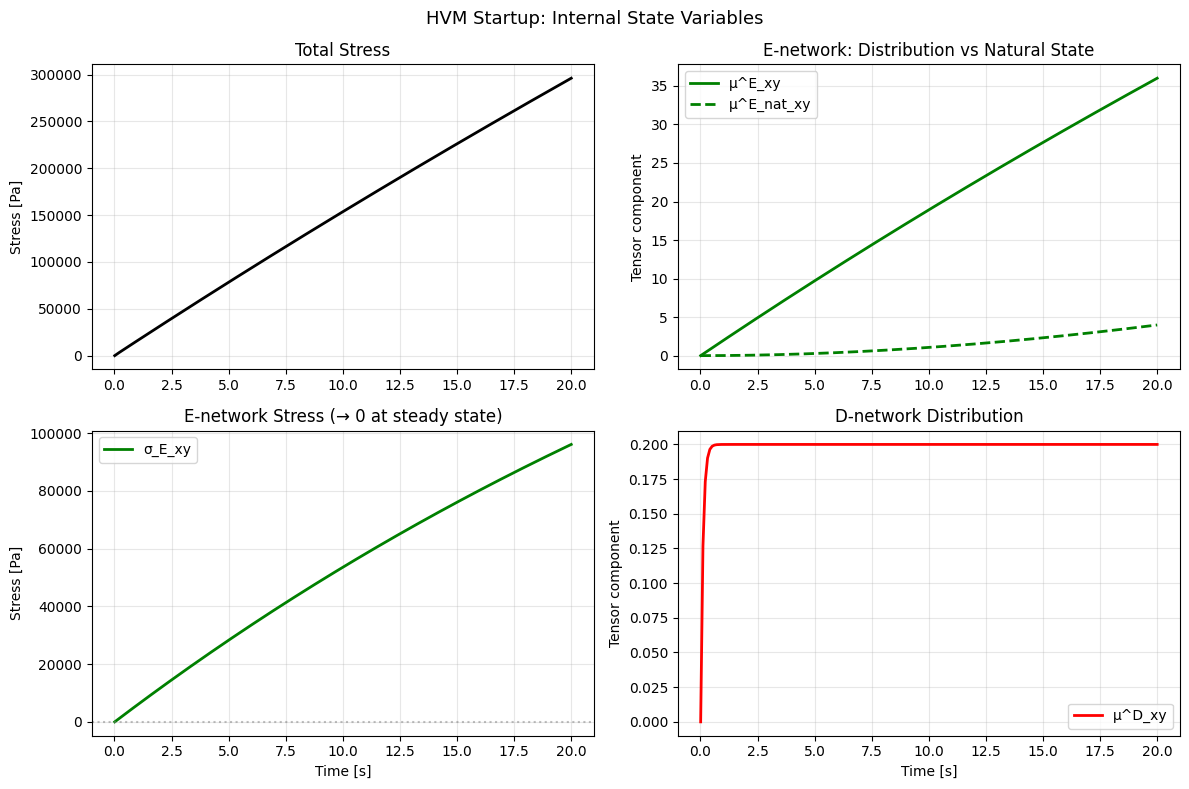

In [5]:
t = np.linspace(0.01, 20, 200)
result = model.simulate_startup(t, gamma_dot=2.0, return_full=True)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0, 0].plot(t, result["stress"], "k-", lw=2)
axes[0, 0].set_ylabel("Stress [Pa]")
axes[0, 0].set_title("Total Stress")
axes[0, 0].grid(True, alpha=0.3)

# E-network: mu_E vs mu_E_nat (scalar xy components)
axes[0, 1].plot(t, result["mu_E_xy"], "g-", lw=2, label="μ^E_xy")
axes[0, 1].plot(t, result["mu_E_nat_xy"], "g--", lw=2, label="μ^E_nat_xy")
axes[0, 1].set_ylabel("Tensor component")
axes[0, 1].set_title("E-network: Distribution vs Natural State")
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Stress difference (drives E-stress)
sigma_E_xy = model.G_E * (result["mu_E_xy"] - result["mu_E_nat_xy"])
axes[1, 0].plot(t, sigma_E_xy, "g-", lw=2, label="σ_E_xy")
axes[1, 0].axhline(0, color="gray", ls=":", alpha=0.5)
axes[1, 0].set_xlabel("Time [s]")
axes[1, 0].set_ylabel("Stress [Pa]")
axes[1, 0].set_title("E-network Stress (→ 0 at steady state)")
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# D-network
axes[1, 1].plot(t, result["mu_D_xy"], "r-", lw=2, label="μ^D_xy")
axes[1, 1].set_xlabel("Time [s]")
axes[1, 1].set_ylabel("Tensor component")
axes[1, 1].set_title("D-network Distribution")
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle("HVM Startup: Internal State Variables", fontsize=13)
plt.tight_layout()
display(fig)
plt.close(fig)

## Key Takeaways

1. **TST overshoot**: Stress-enhanced BER creates an overshoot at moderate-to-high rates
2. **$\sigma_E \to 0$**: The E-network stress vanishes at steady state (vitrimer signature)
3. **Rate dependence**: Higher rates produce larger overshoot and shift it to smaller strains
4. **$\sigma_P$ grows linearly**: Permanent network stores elastic energy without bound
5. **$V_{act}$ controls overshoot magnitude**: This is the primary parameter determined from startup

## Further Reading

- [HVM Model Reference](../../docs/source/models/hvm/hvm.rst) — TST kinetics (stress and stretch coupling)
- [HVM Knowledge Extraction](../../docs/source/models/hvm/hvm_knowledge.rst) — $V_{act}$ determination from startup data

**References:**
1. Vernerey, F.J., Long, R. & Brighenti, R. (2017). *J. Mech. Phys. Solids*, 107, 1-20.

## Next Notebooks

- **Notebook 04**: Creep with vitrimer plastic flow
- **Notebook 05**: Flow curve and subnetwork decomposition